## POS tagging using modified Viterbi

### Data Preparation

In [1]:
#Importing libraries
import nltk


In [2]:
import numpy as np
import pandas as pd
import pprint, time
import random
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
import math

In [3]:
nltk.download('universal_tagset')


[nltk_data] Downloading package universal_tagset to
[nltk_data]     C:\Users\haris\AppData\Roaming\nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


True

In [4]:
# reading the Treebank tagged sentences
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

In [5]:
# samples: Each sentence is a list of (word, pos) tuples

nltk_data[:3]

[[('Pierre', 'NOUN'),
  ('Vinken', 'NOUN'),
  (',', '.'),
  ('61', 'NUM'),
  ('years', 'NOUN'),
  ('old', 'ADJ'),
  (',', '.'),
  ('will', 'VERB'),
  ('join', 'VERB'),
  ('the', 'DET'),
  ('board', 'NOUN'),
  ('as', 'ADP'),
  ('a', 'DET'),
  ('nonexecutive', 'ADJ'),
  ('director', 'NOUN'),
  ('Nov.', 'NOUN'),
  ('29', 'NUM'),
  ('.', '.')],
 [('Mr.', 'NOUN'),
  ('Vinken', 'NOUN'),
  ('is', 'VERB'),
  ('chairman', 'NOUN'),
  ('of', 'ADP'),
  ('Elsevier', 'NOUN'),
  ('N.V.', 'NOUN'),
  (',', '.'),
  ('the', 'DET'),
  ('Dutch', 'NOUN'),
  ('publishing', 'VERB'),
  ('group', 'NOUN'),
  ('.', '.')],
 [('Rudolph', 'NOUN'),
  ('Agnew', 'NOUN'),
  (',', '.'),
  ('55', 'NUM'),
  ('years', 'NOUN'),
  ('old', 'ADJ'),
  ('and', 'CONJ'),
  ('former', 'ADJ'),
  ('chairman', 'NOUN'),
  ('of', 'ADP'),
  ('Consolidated', 'NOUN'),
  ('Gold', 'NOUN'),
  ('Fields', 'NOUN'),
  ('PLC', 'NOUN'),
  (',', '.'),
  ('was', 'VERB'),
  ('named', 'VERB'),
  ('*-1', 'X'),
  ('a', 'DET'),
  ('nonexecutive', 'ADJ'),
 

### In the list mentioned above, each element of the list is a sentence. Also, note that each sentence ends with a full stop '.' whose POS tag is also a '.'. Thus, the POS tag '.' demarcates the end of a sentence.

In [6]:
# Splitting into train and test
random.seed(1234)
train_set, test_set = train_test_split(nltk_data,test_size=0.3)

print(len(train_set))
print(len(test_set))
print(train_set[:40])

2739
1175
[[('Many', 'ADJ'), ('are', 'VERB'), ('far', 'ADV'), ('enough', 'ADV'), ('from', 'ADP'), ('residential', 'ADJ'), ('areas', 'NOUN'), ('*', 'X'), ('to', 'PRT'), ('pass', 'VERB'), ('public', 'ADJ'), ('muster', 'NOUN'), (',', '.'), ('yet', 'CONJ'), ('close', 'ADV'), ('enough', 'ADV'), ('*', 'X'), ('to', 'PRT'), ('permit', 'VERB'), ('family', 'NOUN'), ('visits', 'NOUN'), ('.', '.')], [('I', 'PRON'), ('believe', 'VERB'), ('in', 'ADP'), ('the', 'DET'), ('system', 'NOUN'), ('.', '.')], [('``', '.'), ('Only', 'ADV'), ('five', 'NUM'), ('of', 'ADP'), ('the', 'DET'), ('40', 'NUM'), ('questions', 'NOUN'), ('were', 'VERB'), ('geography', 'NOUN'), ('questions', 'NOUN'), ('.', '.')], [('The', 'DET'), ('branch', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('Bank', 'NOUN'), ('for', 'ADP'), ('Foreign', 'NOUN'), ('Economic', 'NOUN'), ('Affairs', 'NOUN'), ('was', 'VERB'), ('approved', 'VERB'), ('*-1', 'X'), ('last', 'ADJ'), ('spring', 'NOUN'), ('and', 'CONJ'), ('opened', 'VERB'), ('in', 'ADP'), ('July

In [7]:
# Getting list of tagged words
train_tagged_words = [tup for sent in train_set for tup in sent]
test_tagged_words = [tup[0] for sent in test_set for tup in sent]


In [8]:
test_tagged_words = [tup[0] for sent in test_set for tup in sent]


In [9]:
print(len(test_tagged_words))
print(len(train_tagged_words))

30081
70595


In [10]:
train_tagged_words[1:5]

[('are', 'VERB'), ('far', 'ADV'), ('enough', 'ADV'), ('from', 'ADP')]

In [11]:
#Lets check how many unique POS tags in the corpus

tags =  [pair[1] for pair in train_tagged_words]
unique_tags = set(tags)
len(unique_tags)

12

In [12]:
#the unique tags are follows:
print(unique_tags)

{'PRON', 'PRT', 'CONJ', 'ADJ', 'NOUN', 'X', '.', 'ADV', 'NUM', 'VERB', 'DET', 'ADP'}


In [13]:
# tokens 
tokens = [pair[0] for pair in train_tagged_words]
tokens[:10]

['Many',
 'are',
 'far',
 'enough',
 'from',
 'residential',
 'areas',
 '*',
 'to',
 'pass']

In [14]:
# vocabulary
V = set(tokens)
print(len(V))

10145


In [15]:
# number of tags
T = set([pair[1] for pair in train_tagged_words])
len(T)

12

In [16]:
print(T)

{'PRON', 'PRT', 'CONJ', 'ADJ', 'NOUN', 'X', '.', 'ADV', 'NUM', 'VERB', 'DET', 'ADP'}


### POS Tagging Algorithm - HMM
We'll use the HMM algorithm to tag the words. Given a sequence of words to be tagged, the task is to assign the most probable tag to the word.

In other words, to every word w, assign the tag t that maximises the likelihood P(t/w). Since P(t/w) = P(w/t). P(t) / P(w), after ignoring P(w), we have to compute P(w/t) and P(t).

P(w/t) is basically the probability that given a tag (say NN), what is the probability of it being w (say 'building'). This can be computed by computing the fraction of all NNs which are equal to w, i.e.

P(w/t) = count(w, t) / count(t).

The term P(t) is the probability of tag t, and in a tagging task, we assume that a tag will depend only on the previous tag. In other words, the probability of a tag being NN will depend only on the previous tag t(n-1). So for e.g. if t(n-1) is a JJ, then t(n) is likely to be an NN since adjectives often precede a noun (blue coat, tall building etc.).

### Build the vanilla Viterbi based POS tagger

## Emission Probabilities


In [17]:
# computing P(w/t) and storing in T x V matrix
t = len(T)
v = len(V)
w_given_t = np.zeros((t, v))

In [18]:
# compute word given tag: Emission Probability
def word_given_tag(word, tag, train_bag = train_tagged_words):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_w_given_tag = len(w_given_tag_list)
    
    return (count_w_given_tag, count_tag)

In [19]:
# compute tag given tag: tag2(t2) given tag1 (t1), i.e. Transition Probability

def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

In [20]:
# examples
print(t2_given_t1('NOUN', 'DET'))

(3954, 6208)


In [21]:
# creating t x t transition matrix of tags
# each column is t2, each row is t1
# thus M(i, j) represents P(tj given ti)

tags_matrix = np.zeros((len(T), len(T)), dtype='float32')
for i, t1 in enumerate(list(T)):
    for j, t2 in enumerate(list(T)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]

In [22]:
tags_matrix

array([[7.86163565e-03, 1.25786159e-02, 3.66876321e-03, 6.97064996e-02,
        2.04402521e-01, 9.74842757e-02, 4.03563939e-02, 3.35429758e-02,
        7.86163565e-03, 4.95807141e-01, 9.43396240e-03, 1.72955971e-02],
       [2.02520248e-02, 2.70026992e-03, 1.80018006e-03, 8.46084580e-02,
        2.41674170e-01, 1.03510348e-02, 4.50045019e-02, 9.90098994e-03,
        5.62556274e-02, 4.05940592e-01, 1.00360036e-01, 2.11521145e-02],
       [6.21468909e-02, 5.02197118e-03, 0.00000000e+00, 1.17388576e-01,
        3.54048967e-01, 7.53295654e-03, 3.51537988e-02, 5.08474559e-02,
        4.58254851e-02, 1.50031388e-01, 1.19899563e-01, 5.21029495e-02],
       [6.71441376e-04, 1.02954339e-02, 1.70098487e-02, 6.64726943e-02,
        6.96508527e-01, 2.08146814e-02, 6.51298091e-02, 4.25246218e-03,
        2.28290055e-02, 1.32050132e-02, 6.26678625e-03, 7.65443146e-02],
       [4.86859772e-03, 4.29231450e-02, 4.18301970e-02, 1.20721348e-02,
        2.63351381e-01, 2.91122254e-02, 2.42684677e-01, 1.62

In [23]:
# convert the matrix to a df for better readability
tags_df = pd.DataFrame(tags_matrix, columns = list(T), index=list(T))

In [24]:
tags_df

,PRON,PRT,CONJ,ADJ,NOUN,X,.,ADV,NUM,VERB,DET,ADP
PRON,0.007862,0.012579,0.003669,0.069706,0.204403,0.097484,0.040356,0.033543,0.007862,0.495807,0.009434,0.017296
PRT,0.020252,0.002700,0.001800,0.084608,0.241674,0.010351,0.045005,0.009901,0.056256,0.405941,0.100360,0.021152
CONJ,0.062147,0.005022,0.000000,0.117389,0.354049,0.007533,0.035154,0.050847,0.045825,0.150031,0.119900,0.052103
ADJ,0.000671,0.010295,0.017010,0.066473,0.696509,0.020815,0.065130,0.004252,0.022829,0.013205,0.006267,0.076544
NOUN,0.004869,0.042923,0.041830,0.012072,0.263351,0.029112,0.242685,0.016295,0.008793,0.147648,0.013513,0.176909
X,0.052211,0.184682,0.010140,0.016828,0.063862,0.074865,0.167422,0.025243,0.002373,0.204746,0.053506,0.144121
.,0.065983,0.002051,0.060917,0.042943,0.217129,0.026176,0.096381,0.053197,0.080458,0.086490,0.173583,0.094572
ADV,0.014021,0.014925,0.006784,0.123926,0.035278,0.020805,0.134328,0.080054,0.030303,0.343736,0.071913,0.123926
NUM,0.001612,0.025393,0.014510,0.034260,0.351471,0.213624,0.112052,0.003628,0.187424,0.017332,0.002821,0.035873
VERB,0.033491,0.030761,0.005564,0.064777,0.108766,0.216588,0.037165,0.081680,0.023097,0.170919,0.136273,0.090919


In [25]:
tags_df.loc['.', :]

PRON    0.065983
PRT     0.002051
CONJ    0.060917
ADJ     0.042943
NOUN    0.217129
X       0.026176
.       0.096381
ADV     0.053197
NUM     0.080458
VERB    0.086490
DET     0.173583
ADP     0.094572
Name: ., dtype: float32

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

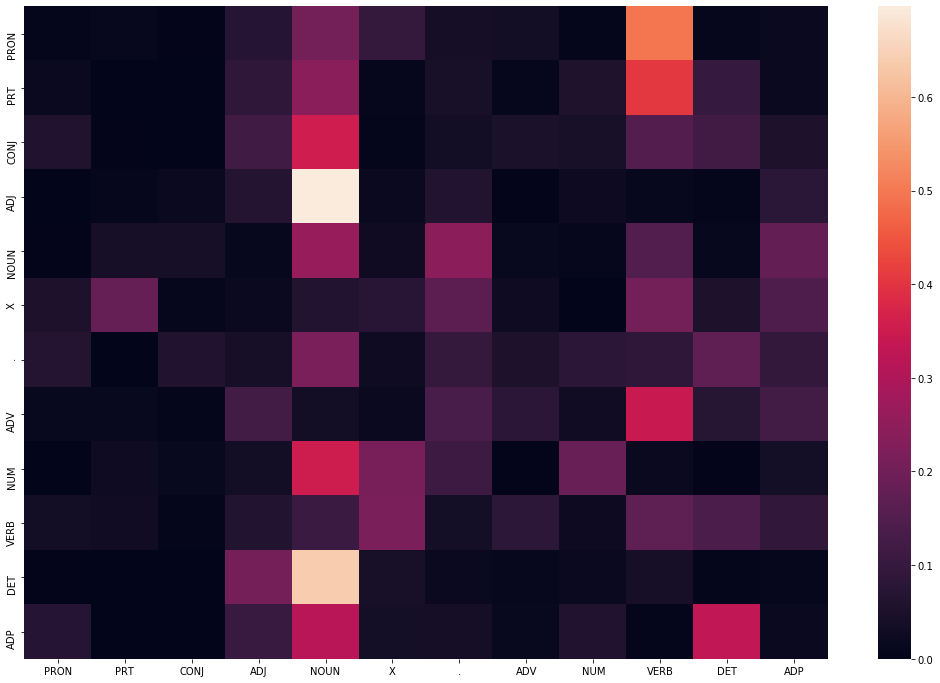

In [27]:
# heatmap of tags matrix
# T(i, j) means P(tag j given tag i)
plt.figure(figsize=(18, 12))
sns.heatmap(tags_df)
plt.show()

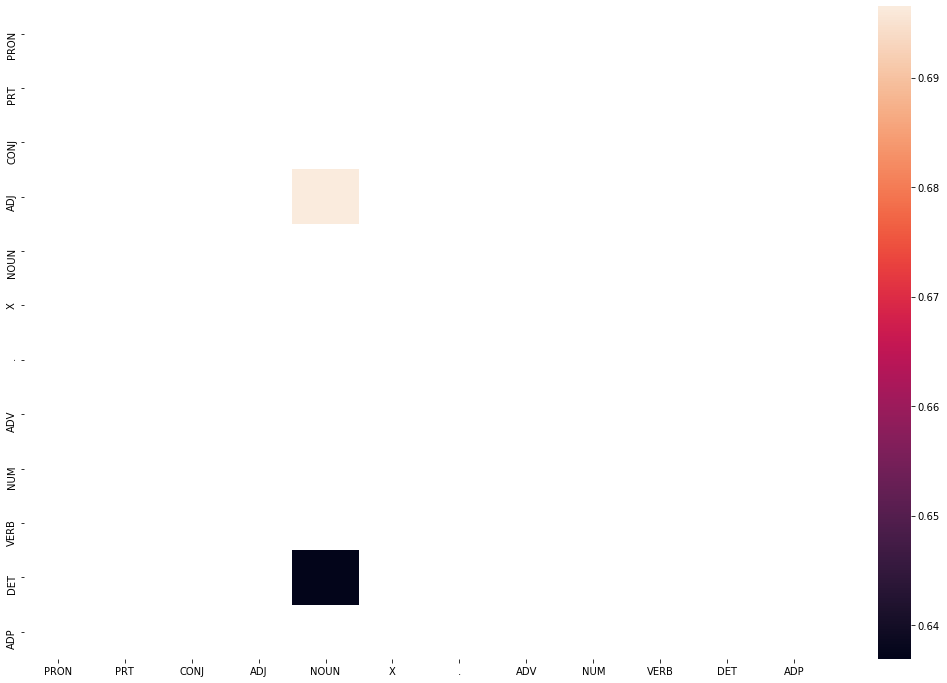

In [28]:
# frequent tags
# filter the df to get P(t2, t1) > 0.5
tags_frequent = tags_df[tags_df>0.5]
plt.figure(figsize=(18, 12))
sns.heatmap(tags_frequent)
plt.show()

## 3. Viterbi Algorithm

Let's now use the computed probabilities P(w, tag) and P(t2, t1) to assign tags to each word in the document. We'll run through each word w and compute P(tag/w)=P(w/tag).P(tag) for each tag in the tag set, and then assign the tag having the max P(tag/w).

We'll store the assigned tags in a list of tuples, similar to the list 'train_tagged_words'. Each tuple will be a (token, assigned_tag). As we progress further in the list, each tag to be assigned will use the tag of the previous token.

Note: P(tag|start) = P(tag|'.') 

In [29]:
len(train_tagged_words)

70595

In [30]:
# Vanilla Viterbi Heuristic
def Viterbi(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

### Evaluating on test set 

In [31]:
# Running on entire test dataset would take more than 3-4hrs. 
# Let's test our Viterbi algorithm on a few sample sentences of test dataset

random.seed(1234)

# choose random 5 sents
rndom = [random.randint(1,len(test_set)) for x in range(5)]

# list of sents
test_run = [test_set[i] for i in rndom]

# list of tagged words
test_run_base = [tup for sent in test_run for tup in sent]

# list of untagged words
test_tagged_words = [tup[0] for sent in test_run for tup in sent]
test_run

[[('The', 'DET'),
  ('latest', 'ADJ'),
  ('results', 'NOUN'),
  ('include', 'VERB'),
  ('some', 'DET'),
  ('unusual', 'ADJ'),
  ('write-downs', 'NOUN'),
  (',', '.'),
  ('which', 'DET'),
  ('*T*-1', 'X'),
  ('had', 'VERB'),
  ('an', 'DET'),
  ('after-tax', 'ADJ'),
  ('impact', 'NOUN'),
  ('of', 'ADP'),
  ('$', '.'),
  ('4.9', 'NUM'),
  ('million', 'NUM'),
  ('*U*', 'X'),
  ('.', '.')],
 [('A', 'DET'),
  ('year', 'NOUN'),
  ('earlier', 'ADV'),
  (',', '.'),
  ('it', 'PRON'),
  ('had', 'VERB'),
  ('profit', 'NOUN'),
  ('of', 'ADP'),
  ('$', '.'),
  ('7.5', 'NUM'),
  ('million', 'NUM'),
  ('*U*', 'X'),
  (',', '.'),
  ('or', 'CONJ'),
  ('18', 'NUM'),
  ('cents', 'NOUN'),
  ('a', 'DET'),
  ('share', 'NOUN'),
  ('.', '.')],
 [('ASLACTON', 'NOUN'), (',', '.'), ('England', 'NOUN')],
 [('A', 'DET'),
  ('majority', 'NOUN'),
  ('of', 'ADP'),
  ('an', 'DET'),
  ('NIH-appointed', 'ADJ'),
  ('panel', 'NOUN'),
  ('recommended', 'VERB'),
  ('late', 'ADV'),
  ('last', 'ADJ'),
  ('year', 'NOUN'),
  ('t

In [32]:
# tagging the test sentences
start = time.time()
tagged_seq = Viterbi(test_tagged_words)
end = time.time()
difference = end-start

In [33]:
print("Time taken in seconds: ", difference)
print(tagged_seq)
#print(test_run_base)

Time taken in seconds:  26.319824695587158
[('The', 'DET'), ('latest', 'ADJ'), ('results', 'NOUN'), ('include', 'VERB'), ('some', 'DET'), ('unusual', 'ADJ'), ('write-downs', 'PRON'), (',', '.'), ('which', 'DET'), ('*T*-1', 'X'), ('had', 'VERB'), ('an', 'DET'), ('after-tax', 'ADJ'), ('impact', 'NOUN'), ('of', 'ADP'), ('$', '.'), ('4.9', 'PRON'), ('million', 'NUM'), ('*U*', 'X'), ('.', '.'), ('A', 'DET'), ('year', 'NOUN'), ('earlier', 'ADJ'), (',', '.'), ('it', 'PRON'), ('had', 'VERB'), ('profit', 'NOUN'), ('of', 'ADP'), ('$', '.'), ('7.5', 'NUM'), ('million', 'NUM'), ('*U*', 'X'), (',', '.'), ('or', 'CONJ'), ('18', 'NUM'), ('cents', 'NOUN'), ('a', 'DET'), ('share', 'NOUN'), ('.', '.'), ('ASLACTON', 'PRON'), (',', '.'), ('England', 'NOUN'), ('A', 'DET'), ('majority', 'NOUN'), ('of', 'ADP'), ('an', 'DET'), ('NIH-appointed', 'PRON'), ('panel', 'NOUN'), ('recommended', 'PRON'), ('late', 'ADJ'), ('last', 'ADJ'), ('year', 'NOUN'), ('that', 'ADP'), ('the', 'DET'), ('research', 'NOUN'), ('conti

In [34]:
# accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 

In [35]:
accuracy = len(check)/len(tagged_seq)

In [40]:
accuracy

0.8811881188118812

In [37]:
incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]

In [38]:
incorrect_tagged_cases

[[('unusual', 'ADJ'), (('write-downs', 'PRON'), ('write-downs', 'NOUN'))],
 [('$', '.'), (('4.9', 'PRON'), ('4.9', 'NUM'))],
 [('year', 'NOUN'), (('earlier', 'ADJ'), ('earlier', 'ADV'))],
 [('.', '.'), (('ASLACTON', 'PRON'), ('ASLACTON', 'NOUN'))],
 [('an', 'DET'), (('NIH-appointed', 'PRON'), ('NIH-appointed', 'ADJ'))],
 [('panel', 'NOUN'), (('recommended', 'PRON'), ('recommended', 'VERB'))],
 [('recommended', 'VERB'), (('late', 'ADJ'), ('late', 'ADV'))],
 [('under', 'ADP'), (('carefully', 'PRON'), ('carefully', 'ADV'))],
 [('carefully', 'ADV'), (('controlled', 'VERB'), ('controlled', 'ADJ'))],
 [('became', 'VERB'), (('embroiled', 'PRON'), ('embroiled', 'VERB'))],
 [('as', 'ADP'), (('anti-abortion', 'PRON'), ('anti-abortion', 'ADJ'))],
 [("'s", 'PRT'), (('uptick', 'VERB'), ('uptick', 'NOUN'))]]

### Solve the problem of unknown words

In [39]:
#As we can see few words are tagged incorrectly

### Viterbi Modification

In [42]:
# we will specify patterns for tagging

patterns = [
    (r'.*ing$', 'VERB'),
    (r'.*ed$', 'VERB'),
    (r'.*es$', 'NOUN'),
    (r'.*s$', 'NOUN'),
    (r'\*T?\*?-[0-9]+$', 'X'),
    (r'^-?[0-9]+(.[0-9]+)$','NUM'),
    (r'.*','NOUN')
    
]
#rule based tags
rule_based_tag = nltk.RegexpTagger(patterns)

In [46]:
# Vanilla Viterbi 2 Heuristic
def Viterbi_2(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = rule_based_tag.tag([word])[0][1]
        
        
        if(pmax==0):
            state_max = rule_based_tag.tag([word])[0][1]
        else:
            if state_max != 'X':
                state_max = T[p.index(pmax)]
        state.append(state_max)
    return list(zip(words, state))

In [47]:
# tagging the test sentences
start = time.time()
tagged_seq = Viterbi_2(test_tagged_words)
end = time.time()
difference = end-start

In [48]:
print("Time taken in seconds: ", difference)
print(tagged_seq)

Time taken in seconds:  16.62334156036377
[('The', 'DET'), ('latest', 'ADJ'), ('results', 'NOUN'), ('include', 'VERB'), ('some', 'DET'), ('unusual', 'ADJ'), ('write-downs', 'NOUN'), (',', '.'), ('which', 'DET'), ('*T*-1', 'X'), ('had', 'VERB'), ('an', 'DET'), ('after-tax', 'ADJ'), ('impact', 'NOUN'), ('of', 'ADP'), ('$', '.'), ('4.9', 'NUM'), ('million', 'NUM'), ('*U*', 'X'), ('.', '.'), ('A', 'DET'), ('year', 'NOUN'), ('earlier', 'ADJ'), (',', '.'), ('it', 'PRON'), ('had', 'VERB'), ('profit', 'NOUN'), ('of', 'ADP'), ('$', '.'), ('7.5', 'NUM'), ('million', 'NUM'), ('*U*', 'X'), (',', '.'), ('or', 'CONJ'), ('18', 'NUM'), ('cents', 'NOUN'), ('a', 'DET'), ('share', 'NOUN'), ('.', '.'), ('ASLACTON', 'NOUN'), (',', '.'), ('England', 'NOUN'), ('A', 'DET'), ('majority', 'NOUN'), ('of', 'ADP'), ('an', 'DET'), ('NIH-appointed', 'VERB'), ('panel', 'NOUN'), ('recommended', 'VERB'), ('late', 'ADJ'), ('last', 'ADJ'), ('year', 'NOUN'), ('that', 'ADP'), ('the', 'DET'), ('research', 'NOUN'), ('continu

#### Evaluating tagging accuracy

In [49]:
# accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
accuracy = len(check)/len(tagged_seq)

In [50]:
accuracy

0.9306930693069307

In [51]:
incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]

In [52]:
incorrect_tagged_cases

[[('year', 'NOUN'), (('earlier', 'ADJ'), ('earlier', 'ADV'))],
 [('an', 'DET'), (('NIH-appointed', 'VERB'), ('NIH-appointed', 'ADJ'))],
 [('recommended', 'VERB'), (('late', 'ADJ'), ('late', 'ADV'))],
 [('under', 'ADP'), (('carefully', 'NOUN'), ('carefully', 'ADV'))],
 [('carefully', 'ADV'), (('controlled', 'VERB'), ('controlled', 'ADJ'))],
 [('as', 'ADP'), (('anti-abortion', 'NOUN'), ('anti-abortion', 'ADJ'))],
 [("'s", 'PRT'), (('uptick', 'VERB'), ('uptick', 'NOUN'))]]

### Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm

In [53]:
#Viterbi_2 which is the first modification has an accuracy of 93% and viterbi approach has accuracy 88%

### Viterbi_3 approach 2

In [59]:
# Vanilla Viterbi 3 2nd approach where we are tagging unknown words using transition probability
def Viterbi_3(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        p_trans = []
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            p_trans.append(transition_p)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        
        if (pmax == 0):
            pmax = max(p_trans)
            state_max = T[p_trans.index(pmax)]
        else:
            state_max = T[p.index(pmax)]
            
            
        state.append(state_max)
    return list(zip(words, state))

In [60]:
# tagging the test sentences
start = time.time()
tagged_seq = Viterbi_3(test_tagged_words)
end = time.time()
difference = end-start
print("Time taken in seconds: ", difference)


Time taken in seconds:  18.74800181388855


In [61]:
# accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
accuracy = len(check)/len(tagged_seq)
accuracy

0.900990099009901

In [62]:
incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]
incorrect_tagged_cases

[[('$', '.'), (('4.9', 'NOUN'), ('4.9', 'NUM'))],
 [('year', 'NOUN'), (('earlier', 'ADJ'), ('earlier', 'ADV'))],
 [('an', 'DET'), (('NIH-appointed', 'NOUN'), ('NIH-appointed', 'ADJ'))],
 [('panel', 'NOUN'), (('recommended', 'NOUN'), ('recommended', 'VERB'))],
 [('recommended', 'VERB'), (('late', 'ADJ'), ('late', 'ADV'))],
 [('under', 'ADP'), (('carefully', 'DET'), ('carefully', 'ADV'))],
 [('carefully', 'ADV'), (('controlled', 'VERB'), ('controlled', 'ADJ'))],
 [('became', 'VERB'), (('embroiled', 'X'), ('embroiled', 'VERB'))],
 [('as', 'ADP'), (('anti-abortion', 'DET'), ('anti-abortion', 'ADJ'))],
 [("'s", 'PRT'), (('uptick', 'VERB'), ('uptick', 'NOUN'))]]

### List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications

In [64]:
#Viterbi

#[[('unusual', 'ADJ'), (('write-downs', 'PRON'), ('write-downs', 'NOUN'))],
# [('$', '.'), (('4.9', 'PRON'), ('4.9', 'NUM'))],
# [('year', 'NOUN'), (('earlier', 'ADJ'), ('earlier', 'ADV'))],
# [('.', '.'), (('ASLACTON', 'PRON'), ('ASLACTON', 'NOUN'))],
# [('an', 'DET'), (('NIH-appointed', 'PRON'), ('NIH-appointed', 'ADJ'))],
# [('panel', 'NOUN'), (('recommended', 'PRON'), ('recommended', 'VERB'))],
# [('recommended', 'VERB'), (('late', 'ADJ'), ('late', 'ADV'))],
# [('under', 'ADP'), (('carefully', 'PRON'), ('carefully', 'ADV'))],
# [('carefully', 'ADV'), (('controlled', 'VERB'), ('controlled', 'ADJ'))],
 #[('became', 'VERB'), (('embroiled', 'PRON'), ('embroiled', 'VERB'))],
 #[('as', 'ADP'), (('anti-abortion', 'PRON'), ('anti-abortion', 'ADJ'))],
 #[("'s", 'PRT'), (('uptick', 'VERB'), ('uptick', 'NOUN'))]]

In [65]:
#Viterbi_2
#[[('year', 'NOUN'), (('earlier', 'ADJ'), ('earlier', 'ADV'))],
 #[('an', 'DET'), (('NIH-appointed', 'VERB'), ('NIH-appointed', 'ADJ'))],
 #[('recommended', 'VERB'), (('late', 'ADJ'), ('late', 'ADV'))],
 #[('under', 'ADP'), (('carefully', 'NOUN'), ('carefully', 'ADV'))],
 #[('carefully', 'ADV'), (('controlled', 'VERB'), ('controlled', 'ADJ'))],
 #[('as', 'ADP'), (('anti-abortion', 'NOUN'), ('anti-abortion', 'ADJ'))],
 #[("'s", 'PRT'), (('uptick', 'VERB'), ('uptick', 'NOUN'))]]

In [66]:
#Viterbi_3
##[[('$', '.'), (('4.9', 'NOUN'), ('4.9', 'NUM'))],
 #[('year', 'NOUN'), (('earlier', 'ADJ'), ('earlier', 'ADV'))],
 #[('an', 'DET'), (('NIH-appointed', 'NOUN'), ('NIH-appointed', 'ADJ'))],
 ##[('panel', 'NOUN'), (('recommended', 'NOUN'), ('recommended', 'VERB'))],
 #[('recommended', 'VERB'), (('late', 'ADJ'), ('late', 'ADV'))],
 #[('under', 'ADP'), (('carefully', 'DET'), ('carefully', 'ADV'))],
 #[('carefully', 'ADV'), (('controlled', 'VERB'), ('controlled', 'ADJ'))],
 #[('became', 'VERB'), (('embroiled', 'X'), ('embroiled', 'VERB'))],
# [('as', 'ADP'), (('anti-abortion', 'DET'), ('anti-abortion', 'ADJ'))],
 #[("'s", 'PRT'), (('uptick', 'VERB'), ('uptick', 'NOUN'))]]

In [63]:
#words such as "Unusual", "write-downs","num", etc were missclassified 
#Also, using viterbi_2 was more beneficial we got the accuracy of 93%


### Now let us evaluate the Viterbi and the modified viterbi in the test sample data set

In [69]:
test_tagged_words = [tup[0] for sent in test_set for tup in sent]


print(len(test_tagged_words))

30081


In [70]:
test_run_base = [tup for sent in test_run for tup in sent]
print(len(test_run_base))

101


In [71]:
test_tagged_words[:3]

['A', 'spokesman', 'for']

In [75]:
test_run_base[:5]

[('The', 'DET'),
 ('latest', 'ADJ'),
 ('results', 'NOUN'),
 ('include', 'VERB'),
 ('some', 'DET')]

In [76]:
t = open('test_sample.txt')
text = t.read()
sample_test = text.splitlines()
t.close()
sample_test[:2]

['Android is a mobile operating system developed by Google.',
 'Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.']

In [79]:
sample_test_words = [word for sent in sample_test for word in sent.split()]

In [81]:
start = time.time()
tagged_seq = Viterbi_2(sample_test_words)
end = time.time()
difference = end-start
print("Time taken in seconds: ", difference)


Time taken in seconds:  52.748701095581055


In [83]:
tagged_seq

[('Android', 'NOUN'),
 ('is', 'VERB'),
 ('a', 'DET'),
 ('mobile', 'ADJ'),
 ('operating', 'NOUN'),
 ('system', 'NOUN'),
 ('developed', 'VERB'),
 ('by', 'ADP'),
 ('Google.', 'NOUN'),
 ('Android', 'NOUN'),
 ('has', 'VERB'),
 ('been', 'VERB'),
 ('the', 'DET'),
 ('best-selling', 'VERB'),
 ('OS', 'NOUN'),
 ('worldwide', 'NOUN'),
 ('on', 'ADP'),
 ('smartphones', 'NOUN'),
 ('since', 'ADP'),
 ('2011', 'NUM'),
 ('and', 'CONJ'),
 ('on', 'ADP'),
 ('tablets', 'NOUN'),
 ('since', 'ADP'),
 ('2013.', 'NOUN'),
 ('Google', 'NOUN'),
 ('and', 'CONJ'),
 ('Twitter', 'NOUN'),
 ('made', 'VERB'),
 ('a', 'DET'),
 ('deal', 'NOUN'),
 ('in', 'ADP'),
 ('2015', 'NUM'),
 ('that', 'ADP'),
 ('gave', 'VERB'),
 ('Google', 'NOUN'),
 ('access', 'NOUN'),
 ('to', 'PRT'),
 ("Twitter's", 'NOUN'),
 ('firehose.', 'NOUN'),
 ('Twitter', 'NOUN'),
 ('is', 'VERB'),
 ('an', 'DET'),
 ('online', 'NOUN'),
 ('news', 'NOUN'),
 ('and', 'CONJ'),
 ('social', 'ADJ'),
 ('networking', 'NOUN'),
 ('service', 'NOUN'),
 ('on', 'ADP'),
 ('which', 'DE

In [84]:
# As we can see the approach has correctly identified the words

In [87]:
# viterbi_3 evaluation
start = time.time()
tagged_seq = Viterbi_3(sample_test_words)
end = time.time()
difference = end-start
print("Time taken in seconds: ", difference)

Time taken in seconds:  52.530213832855225


In [88]:
tagged_seq

[('Android', 'NOUN'),
 ('is', 'VERB'),
 ('a', 'DET'),
 ('mobile', 'ADJ'),
 ('operating', 'NOUN'),
 ('system', 'NOUN'),
 ('developed', 'VERB'),
 ('by', 'ADP'),
 ('Google.', 'DET'),
 ('Android', 'NOUN'),
 ('has', 'VERB'),
 ('been', 'VERB'),
 ('the', 'DET'),
 ('best-selling', 'NOUN'),
 ('OS', 'NOUN'),
 ('worldwide', 'NOUN'),
 ('on', 'ADP'),
 ('smartphones', 'DET'),
 ('since', 'ADP'),
 ('2011', 'DET'),
 ('and', 'CONJ'),
 ('on', 'ADP'),
 ('tablets', 'DET'),
 ('since', 'ADP'),
 ('2013.', 'DET'),
 ('Google', 'NOUN'),
 ('and', 'CONJ'),
 ('Twitter', 'NOUN'),
 ('made', 'VERB'),
 ('a', 'DET'),
 ('deal', 'NOUN'),
 ('in', 'ADP'),
 ('2015', 'DET'),
 ('that', 'ADP'),
 ('gave', 'VERB'),
 ('Google', 'X'),
 ('access', 'NOUN'),
 ('to', 'PRT'),
 ("Twitter's", 'VERB'),
 ('firehose.', 'X'),
 ('Twitter', 'VERB'),
 ('is', 'VERB'),
 ('an', 'DET'),
 ('online', 'NOUN'),
 ('news', 'NOUN'),
 ('and', 'CONJ'),
 ('social', 'ADJ'),
 ('networking', 'NOUN'),
 ('service', 'NOUN'),
 ('on', 'ADP'),
 ('which', 'DET'),
 ('us